<a href="https://githubtocolab.com/Eunseob/purdue_me597/blob/main/lab/lab10/PL10_Colab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prelab 10.2 Machine Learning 3 - Real-time Sound Recognition for Classification

# Problem definition and understanding data flow

## 2.1 Data loading and signal processing

Before we load data and analyze them, let's figure out the experiments for the training data collection. As discussed in the previous session ([Prelab 10.1](https://githubtocolab.com/Eunseob/purdue_me597/blob/main/lab/lab10/PL10_Colab1.ipynb)), we defined the machine's three states: (1) OFF, (2), ON in vacuuming, and (3) ON in air-leaking. The data collection was basically performed in the lab space in a quiet environment. Data collections were made by using the MTConnect of the sound stream in WAV format. Because the WAV format data is made by the MTConnect sound stream, the audio specifications, such as sampling rate, resolution, and so on, were the same as the MTConnect stream. The data collection configuration is illustrated in Figure 7. To make a noisy environment, a loudspeaker was placed near the pump.

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig7.png?raw=true" width="50%">

*Figure 7 System configuration for sound data collection*


Sound signals from the internal sound sensor for each state of the machine were collected for 1 minute. On top of that, simulating other environmental conditions, the same amount of data was collected in a loud environment in which a loudspeaker generated white noise. Therefore, we have three states data and total 6 sound data in [Github repo](https://github.com/Eunseob/purdue_me597/tree/main/lab/lab10/prelab_data). You will figure out the condition in the filename. Note that each data is 1 minute-long. Description for the filename and states is below.



*   **OFF.wav**
  * Machine is turned off, state 1 (OFF)
*   **OFF_with_noise.wav**
  * Machine is turned off, state 1 (OFF)
*   **ON_vacuum.wav**
  * Machine is on in vacuuming, state 2 (ON/Vacuuming)
*   **ON_vacuum_with_noise.wav**
  * Machine is on in vacuuming and noisy environment, state 2 (ON/Vacuuming)
*   **ON_air_leaking.wav**
  * Machine is on in air-leaking, state 3 (ON/Air-leaking)
*   **ON_air_leaking_with_noise.wav**
  * Machine is on in air-leaking and noisy environment, state 3 (ON/Air-leaking)


Let's listen to the sound of each case and then load data to analyze it.

### Loading data

We will use bash command in the code block below to load data in Colab session. Note that you can use Colab interface to upload data instead.

In [2]:
# loading sound data in this Colab session by bash
# It takes a few seconds.
!wget -O OFF.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/OFF.wav?raw=true
!wget -O OFF_with_noise.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/OFF_with_noise.wav?raw=true
!wget -O ON_vacuum.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/ON_vacuum.wav?raw=true
!wget -O ON_vacuum_with_noise.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/ON_vacuum_with_noise.wav?raw=true
!wget -O ON_air_leaking.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/ON_air_leaking.wav?raw=true
!wget -O ON_air_leaking_with_noise.wav https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/ON_air_leaking_with_noise.wav?raw=true

--2023-03-03 04:04:56--  https://github.com/Eunseob/purdue_me597/blob/main/lab/lab10/prelab_data/OFF.wav?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Eunseob/purdue_me597/raw/main/lab/lab10/prelab_data/OFF.wav [following]
--2023-03-03 04:04:56--  https://github.com/Eunseob/purdue_me597/raw/main/lab/lab10/prelab_data/OFF.wav
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Eunseob/purdue_me597/main/lab/lab10/prelab_data/OFF.wav [following]
--2023-03-03 04:04:56--  https://raw.githubusercontent.com/Eunseob/purdue_me597/main/lab/lab10/prelab_data/OFF.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.co

After running the cell above, Files of your Colab session look like the capture below.

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_img1.png?raw=true" width="30%">

Let's play each data in the following code blocks and perform Task 2.1.

In [4]:
from IPython.display import Audio, display

# Filenames for each data
OFF = 'OFF.wav' # OFF state filename
OFF_with_noise = 'OFF_with_noise.wav' # OFF in noisy environment
ON_vacuum = 'ON_vacuum.wav' # ON in vacuuming
ON_vacuum_with_noise = 'ON_vacuum_with_noise.wav' # ON in vacuuming and noisy environment
ON_air_leaking = 'ON_air_leaking.wav' # ON in air-leaking
ON_air_leaking_with_noise = 'ON_air_leaking_with_noise.wav' # On in air-leaking and noisy environment

In [5]:
print(OFF)
display(Audio(OFF))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(OFF_with_noise)
display(Audio(OFF_with_noise))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(ON_vacuum)
display(Audio(ON_vacuum))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(ON_vacuum_with_noise)
display(Audio(ON_vacuum_with_noise))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(ON_air_leaking)
display(Audio(ON_air_leaking))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(ON_air_leaking_with_noise)
display(Audio(ON_air_leaking_with_noise))

Output hidden; open in https://colab.research.google.com to view.

### Task 2.1

After listening to the sound according to each state (condition), do you think you can figure out the state based only on sound? Describe how you hear the sounds depending on the state.



---

Write down your answer here.

---



### Basic signal processing

You definitely tell the differences between OFF and ON states. In addition, you probably "feel" different sounds between ON/vacuuming and ON/air-leaking states. Using basic signal processing, let's analize data to see how signals are different. To analyze audio, we will mainly use Python [librosa](https://librosa.org/doc/latest/index.html#) package. The librosa is a Python package for music and audio analysis.


In [49]:
import librosa
import numpy as np

N_FFT = 2048 # Number of FFT points, because MTConnect stream chunk size is 2048.
y_off, sr = librosa.load(OFF) # y_off is audio data in off state and sr is sampling rate
S_off = librosa.stft(y_off, n_fft=N_FFT, window='hann') # S_off is spectrogram using stft

Text(0.5, 0.98, 'OFF.wav')

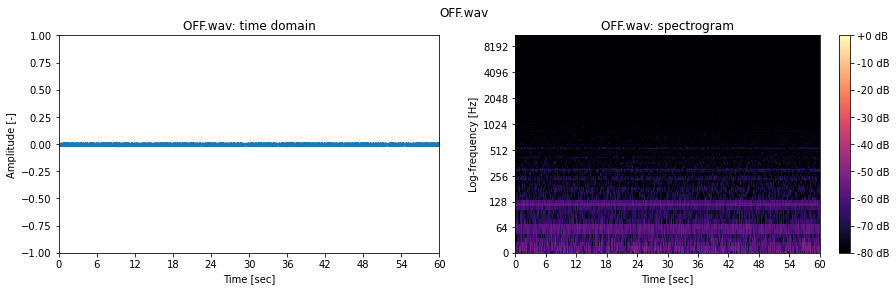

In [54]:
import librosa.display
import matplotlib.pyplot as plt

# This example plots time-domain (raw signal) on the left-hand side and spectrogram on the right-hand side
# Note that legend (color) means relative signal intensity in dB unit in the spectrogram.
# Also, in the spectrogram, the y-axis (frequency) is log scale.
fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
librosa.display.waveplot(y_off, sr=sr, ax=ax[0])
img = librosa.display.specshow(librosa.amplitude_to_db(2*np.abs(S_off)/N_FFT, ref=1), x_axis='time', y_axis='log', ax=ax[1], vmin=-80, vmax=0)
ax[0].set(title=OFF+": time domain", ylim=[-1, 1], xlim=[0, 60], ylabel="Amplitude [-]", xlabel="Time [sec]")
ax[1].set(title=OFF+": spectrogram", ylabel="Log-frequency [Hz]", xlabel="Time [sec]")
cbar = fig.colorbar(img, ax=ax[1], format="%+2.0f dB")
fig.suptitle(OFF)

In [13]:
len(y_off)/sr

59.989342403628115

https://librosa.org/doc/main/generated/librosa.stft.html#librosa.stft

https://librosa.org/doc/main/auto_examples/plot_display.html

https://librosa.org/doc/main/generated/librosa.display.waveshow.html

<br>
Creating GIF in powerpnt

https://www.youtube.com/watch?v=szbFDKVHkOM


<br>
Data augmentation - translate

https://nnart.org/what-is-data-augmentation-in-a-cnn/#:~:text=Data%20augmentation%20is%20the%20addition,model%20robust%20with%20better%20performance.

## Learning Goals

Studetns will be able to:

  1. Understand sound data format and signal processing
  2. Labeling classification for machine learning model
  3. Training CNN (Convolutional Neural Network) model for sound recognition

## 1.1 Introduction

In Lab 10, as the last lab activity, we will implement real-time machine monitoring using sound recognition. Machine sound monitoring is extensively utilized for various applications such as operational state, prognostic and diagnostic monitoring. Because machine-emitted sound contains the operational process information, humans can tell differences based on audible sounds from the machine. Moreover, in the medical industry, a doctor examines a patient using a stethoscope to listen to the sound of organs. Based on the sound they learned and trained, listening to the sound, doctors determine if the patient is healthy. Inspired by this human ability and examining method, Purdue LAMM ([Laboratory for Advanced Multiscale Manufacturing](https://web.ics.purdue.edu/~jun25/)) developed an internal sound sensor and monitoring system as Figure 1. It was also introduced in [Purdue Research Foundation News](https://www.purdue.edu/newsroom/releases/2020/Q3/innovation-uses-stethoscope-to-monitor-machine-quality,-functionality.html).

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig1.png?raw=true" width="90%">

*Figure 1 Sound recognition applications for humans and machines*

Let's think about the auditory pathway of human beings and machine sound monitoring. In the sense of monitoring, ears are sound sensors that can capture pressure/density fluctuations of a medium, normally air. To be specific, the eardrum receives sound signals and the malleus amplifies the signals and transmits them to the cochlea. The cochlea then filters the signals to a logarithmic scale. The filtered and compressed information are received by the auditory cortex and which processes auditory information. Lexicons from knowledge and experience are in the hippocampus. Lastly, based on the process of the hippocampus, the frontal lobe recognizes the sound signals and then executes actions if needed. These proccesses can be applied to machine sound recognition in the same manner. Figure 2 illustrates analogy between auditory pathway of human and machine sound monitoring.

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig2.png?raw=true" width="90%">

*Figure 2 Auditory pathways for sound recognition by human and machine monitoring*

In Lab10 as a hands-on activity, we will perform sound recognition using the internal sound sensor to predict the operational states of a vacuum pump. In this prelab, we will go through 1) sound data by experiments and understanding sound stream by MTConnect, 2) data visualization to create a training dataset,  3) CNN (convolutional neural network) model training for classification, and 4) install relevant Python packages for sound signal processing.

## 1.2 Sound sensor and target machine

The internal sound sensor consists of a stethoscope and a USB microphone. By attaching the microphone at the end of the rubber side of the stethoscope, the sensor captures sounds from the head of the stethoscope. Figure 3 shows configurations of the internal sound sensor. It allows us to collect not airborne sound but structure-borne sound. In acoustic expression, it is able to capture the near-field sound effect of the structure. The diaphragm plays a role in reducing high-frequency components. Whereas, the bell amplifies the low-frequency components (10 - 200 Hz). Therefore, the sound signals from the sensor are some what different from the airborne sound.


<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig3.png?raw=true" width="70%">

*Figure 3 configuration of the internal sound sensor*

The target machine is a vacuum pump for degassing system which we mainly used in [Lab 3](https://colab.research.google.com/github/Eunseob/purdue_me597/blob/main/lab/lab3/L3_Colab1.ipynb) and [Prelab 8.2](https://colab.research.google.com/github/Eunseob/purdue_me597/blob/main/lab/lab8/PL8_Colab2.ipynb). The internal sound sensor was installed on the vacuum pump as Figure 4. Note that the small bell side without a diaphragm was placed on the target surface in this case because of limited space.

<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig4.png?raw=true" width="50%">

*Figure 4 Vacuum pump and sound sensor*

## 1.3 Monitoring system and sound stream flow

The monitoring system and data stream of the sound signals using MTConnect are illustrated in Figure 5. The stethoscope captures sound from the target surface of the machine. The USB microphone collects the analog sound signals and then convert them to the digital signals by ADC (analog-to-digital converter). The MTConnect adapter in the headless server computer samples and converts the digital sound signals (byte arrays, 2<sup>n</sup> number of sample points) to the space delimited 16-bit signed Int arrays with the timestamp. Finally, the sound stream is accessible from the MTConnect agent of the server. By observing MTConnect standard, *DisplacementTimeSeries* data type was used. It contains sound data in **48 kHz sampling rate with 2<sup>11</sup> chunk size and 16-bit depth resolution of the mono-channel**. In other words, each sample (sequence in MTConnect) contains 2<sup>11</sup> (= 2048, chunk size) sound data points. The timestamp of MTconnect is the exact time of the last observation. Therefore, the timestamp of each sound measurement is tracible. Based on this information, perform Task 1.1 below.


<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig5.png?raw=true" width="100%">

*Figure 5 Vacuum pump and sound sensor*

### Task 1.1

With sound (audio) sensing specifications are described above. Answer the following questions.

1. How long does each sample (sequence) in MTConnect stand for? Answer this in the second unit.
  * Hint: Sampling rate is 48 kHz and each sequence has 2048 sample points.



---

Write down your answer to 1 here.

---



2. If you want to get approximately 1 second-long sound signals, how many consequent sequences do you need from the MTConnect agent? 



---

Write down your answer to 2 here.

---



## 1.4 Problem definition and classification

As we did in the previous lab (Prelab8), we will create and implement a machine learning model to predict the operational states of the vacuum pump. We will set the problem as a multi-class classification, whereas the previous lab defined it as anomaly detection using an autoencoder architecture. In other words, in the previous lab, we assumed that the vacuuming is normal and the air leakage is abnormal. It is a straightforward approach to defining an anomaly prediction problem. However, we have another operational state, which is the machine is off. As you saw in Lab9, when the machine is off, the autoencoder model predicts it is abnormal based on the MAE (mean absolute error) threshold. Let's convert the problem definition from anomaly detection to classification. Including the vacuuming and air-leaking states, normally, the vacuum pump has three states (classes) as below. It is illustrated in Figure 6.



*   Class 1 (state 1): OFF
*   Class 2 (state 2): ON, Vacuumming
*   Class 3 (state 3): ON, Air-leaking


<img src="https://github.com/Eunseob/purdue_me597/blob/main/lab/img/prelab10_fig6.png?raw=true" width="70%">

*Figure 5 Operational states for vacuum pump*

Of course, there are many different ways to define the problem including the machine learning model configurations. For example, you may have a combined algorithm from two machine learning models; one is for an operational state (ON/OFF) prediction model and another is for an anomaly detection model (Normal (vacuuming)/Abnormal (air-leaking)). It is able to perform the same prediction/monitoring task for the vacuum pump sound recognition. Yet, we will deal with a multi-class classification using CNN (convolutional neural network). CNN will be described in detail in the following sessions. 

Let's play two video clips below to figure out airborne sound differences between the states. Then perform Task 1.2.

***Video clip 1: ON/vacuuming state***

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('Prelab10_Video1_Air-tight.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

***Video clip 2: ON/air-leaking state***

You see the vacuum gauge and the cover is not closed in the video.

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('Prelab10_Video2_Air-leakage.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

### Task 1.2

Do you think you can determine the operational states between vacuuming and air-leaking only using sound? Describe the differences in terms of sound.



---

Write down your answer here

---



In the following session, we will go through sound signal processing and labeling.

<br></br>

Please continue to [Prelab 10.2 here](https://colab.research.google.com/github/Eunseob/purdue_me597/blob/main/lab/lab10/PL10_Colab2.ipynb).
